# Library & Setting

In [1]:
# 기타
import warnings
warnings.filterwarnings(action='ignore')

# 전처리
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tq

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
sns.set_style('whitegrid')
path = 'C:/Windows/Fonts/malgun.ttf'
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)
%matplotlib inline

# 모델링
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import lightgbm as lgb
import joblib

# Feature Engineering

## 데이터 불러오기

In [2]:
cks_dtype = {'clnt_id':'int64',
             'sess_id':'int64',
             'hit_seq':'int64',
             'action_type':'int64',
             'biz_unit':'category',
             'sess_dt':'object',
             'hit_tm':'object',
             'hit_pss_tm':'int64',
             'trans_id':'float64',
             'sech_kwd':'object',
             'tot_pag_view_ct':'float64',
             'tot_sess_hr_v':'float64',
             'trfc_src':'category',
             'dvc_ctg_nm':'object',
             'pd_c':'object',
             'de_dt':'object',
             'de_tm':'object',
             'buy_am':'int64',
             'buy_ct':'int64',
             'clnt_gender':'category',
             'clnt_age':'float64',
             'clac_nm1':'category',
             'clac_nm2':'category',
             'clac_nm3':'category'}

online = pd.read_csv('./DATA/온라인 행동 정보(CKS).csv', dtype=cks_dtype)

## 실시간 행동 유형(realtime)

In [3]:
part = online.groupby(['clnt_id','sess_id','hit_seq','action_type']).size().to_frame('count').reset_index()

output = pd.DataFrame()
for i in tq(range(8)):
    data = part[part['action_type']==i].reset_index(drop=True)
    data[f'realtime_act_{i}'] = data.groupby(['clnt_id','sess_id','hit_seq'])['count'].transform(lambda x: x.sum())
    output = pd.concat([output,data], axis=0, sort=True)
    
output = output.fillna(0).sort_values(['clnt_id','sess_id','hit_seq']).reset_index(drop=True)

for i in tq(range(8)):
    output[f'realtime_act_{i}'] = output.groupby(['clnt_id','sess_id'])[f'realtime_act_{i}'].transform(lambda x: x.cumsum())

output = output[['clnt_id','sess_id','hit_seq',
         'realtime_act_0','realtime_act_1','realtime_act_2','realtime_act_3',
         'realtime_act_4','realtime_act_5','realtime_act_6','realtime_act_7']].reset_index(drop=True)

output.to_csv('./tracker/add_01_realtime_act.csv', index=False)

## 흔적(trace)

### 페이지 뷰 수, 총 세션 시간

In [4]:
part = online.groupby(['clnt_id','sess_id'])['tot_pag_view_ct','tot_sess_hr_v'].agg(sum).reset_index()

#### 페이지 뷰 수

In [5]:
output = part.copy()
output['temp'] = output.groupby(['clnt_id'])['tot_pag_view_ct'].transform(lambda x: x.cumsum())
output['trace_tot_pv'] = output.groupby('clnt_id')['temp'].transform(lambda x: x.shift(1))

output = output.fillna(0).reset_index(drop=True)
trc_column = output.columns[output.columns.str.match('trace')].tolist()
output = output[['clnt_id','sess_id'] + trc_column]

def avgmaker(x, variable):
    if x==1:
        variable = variable
    else:
        variable = variable/(x-1)
    return(variable)

output['trace_tot_pv_avg'] = output.apply(lambda x: avgmaker(x['sess_id'],x['trace_tot_pv']), axis=1)
output_pv = output.copy()

#### 총 세션 시간

In [6]:
output = part.copy()
output['temp'] = output.groupby(['clnt_id'])['tot_sess_hr_v'].transform(lambda x: x.cumsum())
output['trace_tot_hr'] = output.groupby('clnt_id')['temp'].transform(lambda x: x.shift(1))

output = output.fillna(0).reset_index(drop=True)
trc_column = output.columns[output.columns.str.match('trace')].tolist()
output = output[['clnt_id','sess_id'] + trc_column]

def avgmaker(x, variable):
    if x==1:
        variable = variable
    else:
        variable = variable/(x-1)
    return(variable)

output['trace_tot_hr_avg'] = output.apply(lambda x: avgmaker(x['sess_id'],x['trace_tot_hr']), axis=1)
output_hr = output.copy()

#### 페이지 서핑 속도

In [7]:
output = part.copy()
output['pv_hr'] = output['tot_pag_view_ct']/output['tot_sess_hr_v']

output['temp'] = output.groupby(['clnt_id'])['pv_hr'].transform(lambda x: x.cumsum())
output['trace_pv_hr'] = output.groupby('clnt_id')['temp'].transform(lambda x: x.shift(1))

output = output.fillna(0).reset_index(drop=True)
trc_column = output.columns[output.columns.str.match('trace')].tolist()
output = output[['clnt_id','sess_id'] + trc_column]

def avgmaker(x, variable):
    if x==1:
        variable = variable
    else:
        variable = variable/(x-1)
    return(variable)

output['trace_pv_hr_avg'] = output.apply(lambda x: avgmaker(x['sess_id'],x['trace_pv_hr']), axis=1)
output_pv_hr = output.copy()

In [8]:
output = pd.merge(output_pv, output_hr, how='left', on=['clnt_id','sess_id'])
output = pd.merge(output, output_pv_hr, how='left', on=['clnt_id','sess_id'])
output.to_csv('./tracker/add_02_trace_pv_hr.csv', index=False)

### 행동 유형별

#### 도달 시간

In [9]:
part = online.groupby(['clnt_id','sess_id','action_type'])['hit_pss_tm'].sum().to_frame().reset_index()

output = pd.DataFrame()
for i in tq(range(0,8)):
    data = part[part['action_type']==i].reset_index(drop=True)
    data['temp'] = data.groupby(['clnt_id'])['hit_pss_tm'].transform(lambda x: x.cumsum())
    data[f'trace_tm_act_{i}'] = data.groupby('clnt_id')['temp'].transform(lambda x: x.shift(1))
    output = pd.concat([output,data], axis=0, sort=True)
    
output = output.fillna(0).reset_index(drop=True)
trc_column = output.columns[output.columns.str.match('trace')].tolist()
output = output[['clnt_id','sess_id'] + trc_column]
output = output.groupby(['clnt_id','sess_id'])[trc_column].agg(sum).reset_index()

def avgmaker(x, variable):
    if x==1:
        variable = variable
    else:
        variable = variable/(x-1)
    return(variable)

for i in range(0,8):
    output[f'trace_tm_act_avg_{i}'] = output.apply(lambda x: avgmaker(x['sess_id'],x[f'trace_tm_act_{i}']), axis=1)

output_act_tm = output.copy()

#### 빈도

In [10]:
part = online.groupby(['clnt_id','sess_id','action_type']).size().to_frame('count').reset_index()

output = pd.DataFrame()
for i in tq(range(0,8)):
    data = part[part['action_type']==i].reset_index(drop=True)
    data['temp'] = data.groupby(['clnt_id'])['count'].transform(lambda x: x.cumsum())
    data[f'trace_cnt_act_{i}'] = data.groupby('clnt_id')['temp'].transform(lambda x: x.shift(1))
    output = pd.concat([output,data], axis=0, sort=True)
    
output = output.fillna(0).reset_index(drop=True)
trc_column = output.columns[output.columns.str.match('trace')].tolist()
output = output[['clnt_id','sess_id'] + trc_column]
output = output.groupby(['clnt_id','sess_id'])[trc_column].agg(sum).reset_index()

def avgmaker(x, variable):
    if x==1:
        variable = variable
    else:
        variable = variable/(x-1)
    return(variable)

for i in range(0,8):
    output[f'trace_cnt_act_avg_{i}'] = output.apply(lambda x: avgmaker(x['sess_id'],x[f'trace_cnt_act_{i}']), axis=1)

output_act_cnt = output.copy()

In [11]:
output = pd.merge(output_act_tm, output_act_cnt, how='left', on=['clnt_id','sess_id'])
output.to_csv('./tracker/add_03_trace_act_type.csv', index=False)

### 기기 유형

In [12]:
dvc = online['dvc_ctg_nm'].unique()
print(dvc)

part = online.groupby(['clnt_id','sess_id','dvc_ctg_nm']).size().to_frame('count').reset_index()

output = pd.DataFrame()
for i in tq(dvc):
    data = part[part['dvc_ctg_nm']==i].reset_index(drop=True)
    data['temp'] = data.groupby(['clnt_id'])['count'].transform(lambda x: x.cumsum())
    data[f'trace_cnt_dvc_{i}'] = data.groupby('clnt_id')['temp'].transform(lambda x: x.shift(1))
    output = pd.concat([output,data], axis=0, sort=True)
    
output = output.reset_index(drop=True)
trc_column = output.columns[output.columns.str.match('trace')].tolist()
output = output[['clnt_id','sess_id'] + trc_column].fillna(0)
output = output.groupby(['clnt_id','sess_id'])[trc_column].agg(sum).reset_index()

def avgmaker(x, variable):
    if x==1:
        variable = variable
    else:
        variable = variable/(x-1)
    return(variable)

for i in dvc:
    output[f'trace_cnt_avg_dvc_{i}'] = output.apply(lambda x: avgmaker(x['sess_id'],x[f'trace_cnt_dvc_{i}']), axis=1)

output.to_csv('./tracker/add_04_trace_dvc.csv', index=False)

['mobile_app' 'unknown' 'mobile_web' 'PC']


### 유입 채널

In [13]:
trfc = online['trfc_src'].unique()
print(trfc)

part = online.groupby(['clnt_id','sess_id','trfc_src']).size().to_frame('count').reset_index()

output = pd.DataFrame()
for i in tq(trfc):
    data = part[part['trfc_src']==i].reset_index(drop=True)
    data['temp'] = data.groupby(['clnt_id'])['count'].transform(lambda x: x.cumsum())
    data[f'trace_cnt_trfc_{i}'] = data.groupby('clnt_id')['temp'].transform(lambda x: x.shift(1))
    output = pd.concat([output,data], axis=0, sort=True)
    
output = output.reset_index(drop=True)
trc_column = output.columns[output.columns.str.match('trace')].tolist()
output = output[['clnt_id','sess_id'] + trc_column].fillna(0)
output = output.groupby(['clnt_id','sess_id'])[trc_column].agg(sum).reset_index()

def avgmaker(x, variable):
    if x==1:
        variable = variable
    else:
        variable = variable/(x-1)
    return(variable)

for i in trfc:
    output[f'trace_cnt_avg_trfc_{i}'] = output.apply(lambda x: avgmaker(x['sess_id'],x[f'trace_cnt_trfc_{i}']), axis=1)

output.to_csv('./tracker/add_05_trace_trfc.csv', index=False)

[unknown, DIRECT, PUSH, PORTAL_1, WEBSITE, PORTAL_2, PORTAL_3]
Categories (7, object): [unknown, DIRECT, PUSH, PORTAL_1, WEBSITE, PORTAL_2, PORTAL_3]


## 모델링 데이터

### 회원

In [14]:
customer = pd.read_csv('./DATA/고객 정보(CKS).csv', dtype=cks_dtype)
add_01 = pd.read_csv('./tracker/add_01_realtime_act.csv')
add_02 = pd.read_csv('./tracker/add_02_trace_pv_hr.csv')
add_03 = pd.read_csv('./tracker/add_03_trace_act_type.csv')
add_04 = pd.read_csv('./tracker/add_04_trace_dvc.csv')
add_05 = pd.read_csv('./tracker/add_05_trace_trfc.csv')

In [15]:
def newcategorymaker(gender, age):
    if gender=='F':
        if age==20:
            x = 0
        elif age==30:
            x = 1
        elif age==40:
            x = 2
        elif age==50:
            x = 3
        elif age==60:
            x = 4
        else:
            x = np.NaN
    else:
        if age==20:
            x = 5
        elif age==30:
            x = 6
        elif age==40:
            x = 7
        elif age==50:
            x = 8
        elif age==60:
            x = 9
        else:
            x = np.NaN
    return x

In [16]:
id_known = customer[customer['clnt_gender'].notnull()].copy()
id_known['clnt_type'] = id_known.apply(lambda x: newcategorymaker(x['clnt_gender'],x['clnt_age']), axis=1)
known = online[online['clnt_id'].isin(id_known['clnt_id'])]
known = known.merge(id_known, how='left', on='clnt_id')

In [17]:
known['weekday'] = pd.to_datetime(known['sess_dt'], format='%Y%m%d').apply(lambda x:x.weekday())
known['time'] = pd.to_datetime(known['hit_tm']).apply(lambda x:x.hour)

In [18]:
known = known.drop(columns=['sess_dt','hit_tm','trans_id','sech_kwd',
                            'tot_pag_view_ct','tot_sess_hr_v','clnt_gender','clnt_age'])

In [19]:
known = known.merge(add_01,how='left',on=['clnt_id','sess_id','hit_seq'])
known = known.merge(add_02,how='left',on=['clnt_id','sess_id'])
known = known.merge(add_03,how='left',on=['clnt_id','sess_id'])
known = known.merge(add_04,how='left',on=['clnt_id','sess_id'])
known = known.merge(add_05,how='left',on=['clnt_id','sess_id'])

In [20]:
known = known[known['clnt_type'].notnull()].reset_index(drop=True)
known.to_csv('./tracker/known.csv', index=False)

### 비회원

In [21]:
id_unknown = customer[customer['clnt_gender'].isnull()]
unknown = online[online['clnt_id'].isin(id_unknown['clnt_id'])].copy()

In [22]:
unknown['weekday'] = pd.to_datetime(unknown['sess_dt'], format='%Y%m%d').apply(lambda x:x.weekday())
unknown['time'] = pd.to_datetime(unknown['hit_tm']).apply(lambda x:x.hour)

In [23]:
unknown = unknown.drop(columns=['sess_dt','hit_tm','trans_id','sech_kwd',
                                'tot_pag_view_ct','tot_sess_hr_v'])

In [24]:
unknown = unknown.merge(add_01,how='left',on=['clnt_id','sess_id','hit_seq'])
unknown = unknown.merge(add_02,how='left',on=['clnt_id','sess_id'])
unknown = unknown.merge(add_03,how='left',on=['clnt_id','sess_id'])
unknown = unknown.merge(add_04,how='left',on=['clnt_id','sess_id'])
unknown = unknown.merge(add_05,how='left',on=['clnt_id','sess_id'])

In [25]:
unknown = unknown.reset_index(drop=True)
unknown.to_csv('./tracker/unknown.csv', index=False)

# Modeling

## 데이터 불러오기

In [26]:
known = pd.read_csv('./tracker/known.csv')
for_train = known.copy()

- `clnt_id`: 고객 번호
- `sess_id`: 세션 번호
- `hit_seq`: 행동 번호
- `action_type`: 행동 유형
- `biz_unit`: 업종 분류
- `hit_pss_tm`: 해당 hit_seq 까지의 도달 시간
- `trfc_src`: 유입 채널 유형
- `dvc_ctg_nm`: 접속 기기 유형
- `clnt_type`: 고객 유형
- `weekday`: 요일(월~일)
- `time`: 시간대(0~23)
- `realtime_act`: 행동 유형별 실시간 누적 카운트(0~7)
- `trace_tot_pv/hr/pv_hr`: 누적 총 페이지 뷰 수/총 세션 시간/페이지 서핑 속도
- `trace_tot_pv/hr/pv_hr_avg`: 누적 평균 페이지 뷰 수/총 세션 시간/페이지 서핑 속도
- `trace_tm_act`: 행동 유형별 누적 도달 시간(0~7)
- `trace_tm_act_avg`: 행동 유형별 누적 평균 도달 시간(0~7)
- `trace_cnt_act`: 행동 유형별 누적 카운트(0~7)
- `trace_cnt_act_avg`: 행동 유형별 누적 평균 카운트(0~7)
- `trace_cnt_dvc`: 기기 유형별 누적 카운트
- `trace_cnt_avg_dvc`: 기기 유형별 누적 평균 카운트
- `trace_cnt_trfc`: 유입 채널별 누적 카운트
- `trace_cnt_trfc_dvc`: 유입 채널별 누적 평균 카운트

##  기본 모델

In [27]:
# dvc_ctg_nm
encoder_dvc = LabelEncoder()
encoder_dvc.fit(for_train['dvc_ctg_nm'])
for_train['dvc_ctg_nm'] = encoder_dvc.transform(for_train['dvc_ctg_nm'])

# trfc_src
encoder_trfc = LabelEncoder()
encoder_trfc.fit(for_train['trfc_src'])
for_train['trfc_src'] = encoder_trfc.transform(for_train['trfc_src'])

# biz_unit
encoder_biz = LabelEncoder()
encoder_biz.fit(for_train['biz_unit'])
for_train['biz_unit'] = encoder_biz.transform(for_train['biz_unit'])

- lightgbm 모델은 categorical 데이터를 문자로 인식하지 못하기 때문에 숫자형으로 바꿔줘야 합니다. 유입 채널과 기기 유형을 숫자형으로 변경합니다.

In [28]:
target = for_train['clnt_type']
for_train = for_train.drop(columns=['clnt_id','clnt_type'])

- 타겟과 변수를 분리합니다.

In [29]:
X, test_X, y, test_y = train_test_split(for_train, target, test_size=0.2, random_state=0)
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.375, random_state=0)

- 전체 데이터를 5:3:2 비율로 train, valid, test 로 분리합니다. 랜덤 시드는 0을 사용합니다.

In [30]:
predictors = train_X.columns.tolist()
categorical = ['action_type','trfc_src','dvc_ctg_nm','weekday','time','biz_unit']

dtrain = lgb.Dataset(data=train_X.values, label=train_y,
                     feature_name=predictors, categorical_feature=categorical)
dvalid = lgb.Dataset(data=valid_X.values, label=valid_y,
                     feature_name=predictors, categorical_feature=categorical)

- lightgbm에 사용 가능한 데이터 형태로 변형합니다.

In [31]:
params = {
    'boosting':'gbdt',
    'objective':'multiclass',
    'metric':'softmax',
    'num_class':10,
    'learning_rate':0.1,
    'random_state':0
    }

tracker_basic = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=1000,
    early_stopping_rounds=50,
    valid_sets=dvalid,
    valid_names='valid',
    verbose_eval=False
    )

joblib.dump(tracker_basic, './tracker/tracker_basic.pkl')

['./tracker/tracker_basic.pkl']

- 다음과 같은 파라미터로 트래커 모델을 학습하고 Tracker 경로에 tracker_basic.pkl 으로 모델을 저장합니다.

## 모델 개선

In [32]:
tracker_basic = joblib.load('./tracker/tracker_basic.pkl')

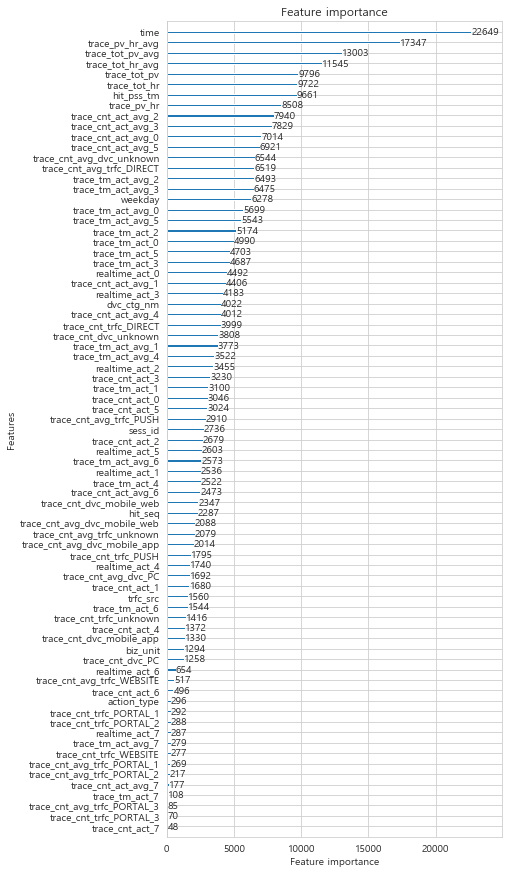

In [33]:
lgb.plot_importance(tracker_basic, figsize=(6,15))

- 저장된 모델을 다시 불러와 변수 중요도를 살펴봅니다.

In [34]:
df_feature = pd.DataFrame({'feature':tracker_basic.feature_name(),
                           'importance':tracker_basic.feature_importance()})

In [35]:
standard = np.quantile(df_feature['importance'], 0.25)
print(f'변수 중요도 75% 기준선은 {standard} 입니다.')
standard_feature = df_feature.loc[df_feature['importance']>=standard,'feature'].tolist()
print(standard_feature)

변수 중요도 75% 기준선은 1372.0 입니다.
['sess_id', 'hit_seq', 'hit_pss_tm', 'trfc_src', 'dvc_ctg_nm', 'weekday', 'time', 'realtime_act_0', 'realtime_act_1', 'realtime_act_2', 'realtime_act_3', 'realtime_act_4', 'realtime_act_5', 'trace_tot_pv', 'trace_tot_pv_avg', 'trace_tot_hr', 'trace_tot_hr_avg', 'trace_pv_hr', 'trace_pv_hr_avg', 'trace_tm_act_0', 'trace_tm_act_1', 'trace_tm_act_2', 'trace_tm_act_3', 'trace_tm_act_4', 'trace_tm_act_5', 'trace_tm_act_6', 'trace_tm_act_avg_0', 'trace_tm_act_avg_1', 'trace_tm_act_avg_2', 'trace_tm_act_avg_3', 'trace_tm_act_avg_4', 'trace_tm_act_avg_5', 'trace_tm_act_avg_6', 'trace_cnt_act_0', 'trace_cnt_act_1', 'trace_cnt_act_2', 'trace_cnt_act_3', 'trace_cnt_act_4', 'trace_cnt_act_5', 'trace_cnt_act_avg_0', 'trace_cnt_act_avg_1', 'trace_cnt_act_avg_2', 'trace_cnt_act_avg_3', 'trace_cnt_act_avg_4', 'trace_cnt_act_avg_5', 'trace_cnt_act_avg_6', 'trace_cnt_dvc_mobile_web', 'trace_cnt_dvc_unknown', 'trace_cnt_avg_dvc_mobile_app', 'trace_cnt_avg_dvc_unknown', 'trace_

- 변수 중요도 상위 75%를 기준선으로 하여 그 미만으로 중요도가 낮은 변수는 학습에 참여시키지 않도록 합니다. 

In [36]:
dtrain = lgb.Dataset(data=train_X[standard_feature].values, label=train_y,
                      feature_name=standard_feature, categorical_feature=['trfc_src','dvc_ctg_nm','weekday','time'])
dvalid = lgb.Dataset(data=valid_X[standard_feature].values, label=valid_y,
                      feature_name=standard_feature, categorical_feature=['trfc_src','dvc_ctg_nm','weekday','time'])

params = {
    'boosting':'gbdt',
    'objective':'multiclass',
    'metric':'softmax',
    'num_class':10,
    'learning_rate':0.1,
    'random_state':0
    }

tracker_improved = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=1000,
    early_stopping_rounds=50,
    valid_sets=dvalid,
    valid_names='valid',
    verbose_eval=False
    )

joblib.dump(tracker_improved, './tracker/tracker_improved.pkl')

['./tracker/tracker_improved.pkl']

- 변수 중요도가 상위 75% 이상인 변수로 트래커 모델을 학습하고 Tracker 경로에 tracker_improved.pkl 으로 모델을 저장합니다.

## 검증
- 테스트 데이터의 실제값과 예측값을 비교한 정확도(Accuracy)를 사용합니다.

$$ 정확도 = {Correct \over All} $$

In [37]:
tracker_basic = joblib.load('./tracker/tracker_basic.pkl')
tracker_improved = joblib.load('./tracker/tracker_improved.pkl')

In [38]:
y_true = test_y.values

pred = pd.DataFrame(tracker_basic.predict(test_X))
y_pred = pred.apply(lambda x: x.idxmax(), axis=1)

acc = accuracy_score(y_true, y_pred)
print(f'기본 모델의 정확도는 {round(acc,3)} 입니다.')

기본 모델의 정확도는 0.866 입니다.


In [39]:
y_true = test_y.values

pred = pd.DataFrame(tracker_improved.predict(test_X[tracker_improved.feature_name()]))
y_pred = pred.apply(lambda x: x.idxmax(), axis=1)

acc = accuracy_score(y_true, y_pred)
print(f'개선 모델의 정확도는 {round(acc,3)} 입니다.')

개선 모델의 정확도는 0.867 입니다.


- 개선 모델은 정확도가 높고, 모든 변수를 사용한 모델보다 변수를 적게 사용합니다. 따라서 개선 모델을 최종 모델로 선정합니다.

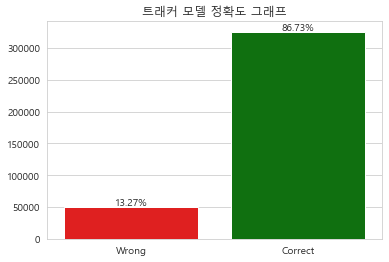

In [40]:
piece = pd.DataFrame({
    'actual':y_true,
    'pred':y_pred
    })

piece['acc'] = piece.apply(lambda x: 1 if x['actual']==x['pred'] else 0, axis=1)

total = len(piece)
correct = round(piece['acc'].sum()/total*100,2)
wrong = round((total-piece['acc'].sum())/total*100,2)

sns.countplot(piece['acc'], palette={0:'red',1:'green'})
plt.xticks(ticks=[0,1], labels=['Wrong','Correct'])
plt.title('트래커 모델 정확도 그래프')
plt.xlabel(''); plt.ylabel('')
plt.text(x=0, y=total-piece['acc'].sum()+3000, s=f'{wrong}%', horizontalalignment='center')
plt.text(x=1, y=piece['acc'].sum()+3000, s=f'{correct}%', horizontalalignment='center')
plt.savefig('./tracker/트래커 모델 정확도 그래프.png', dpi=300)
plt.show()

In [41]:
# 환경변수 설정에 따라 실행되지 않을 수도 있습니다.
# import graphviz
# lgb.create_tree_digraph(tracker_improved).render('./reference/Tracker Model Algorithm', format='png')

- 결정나무 그래프를 reference 폴더에 저장합니다.

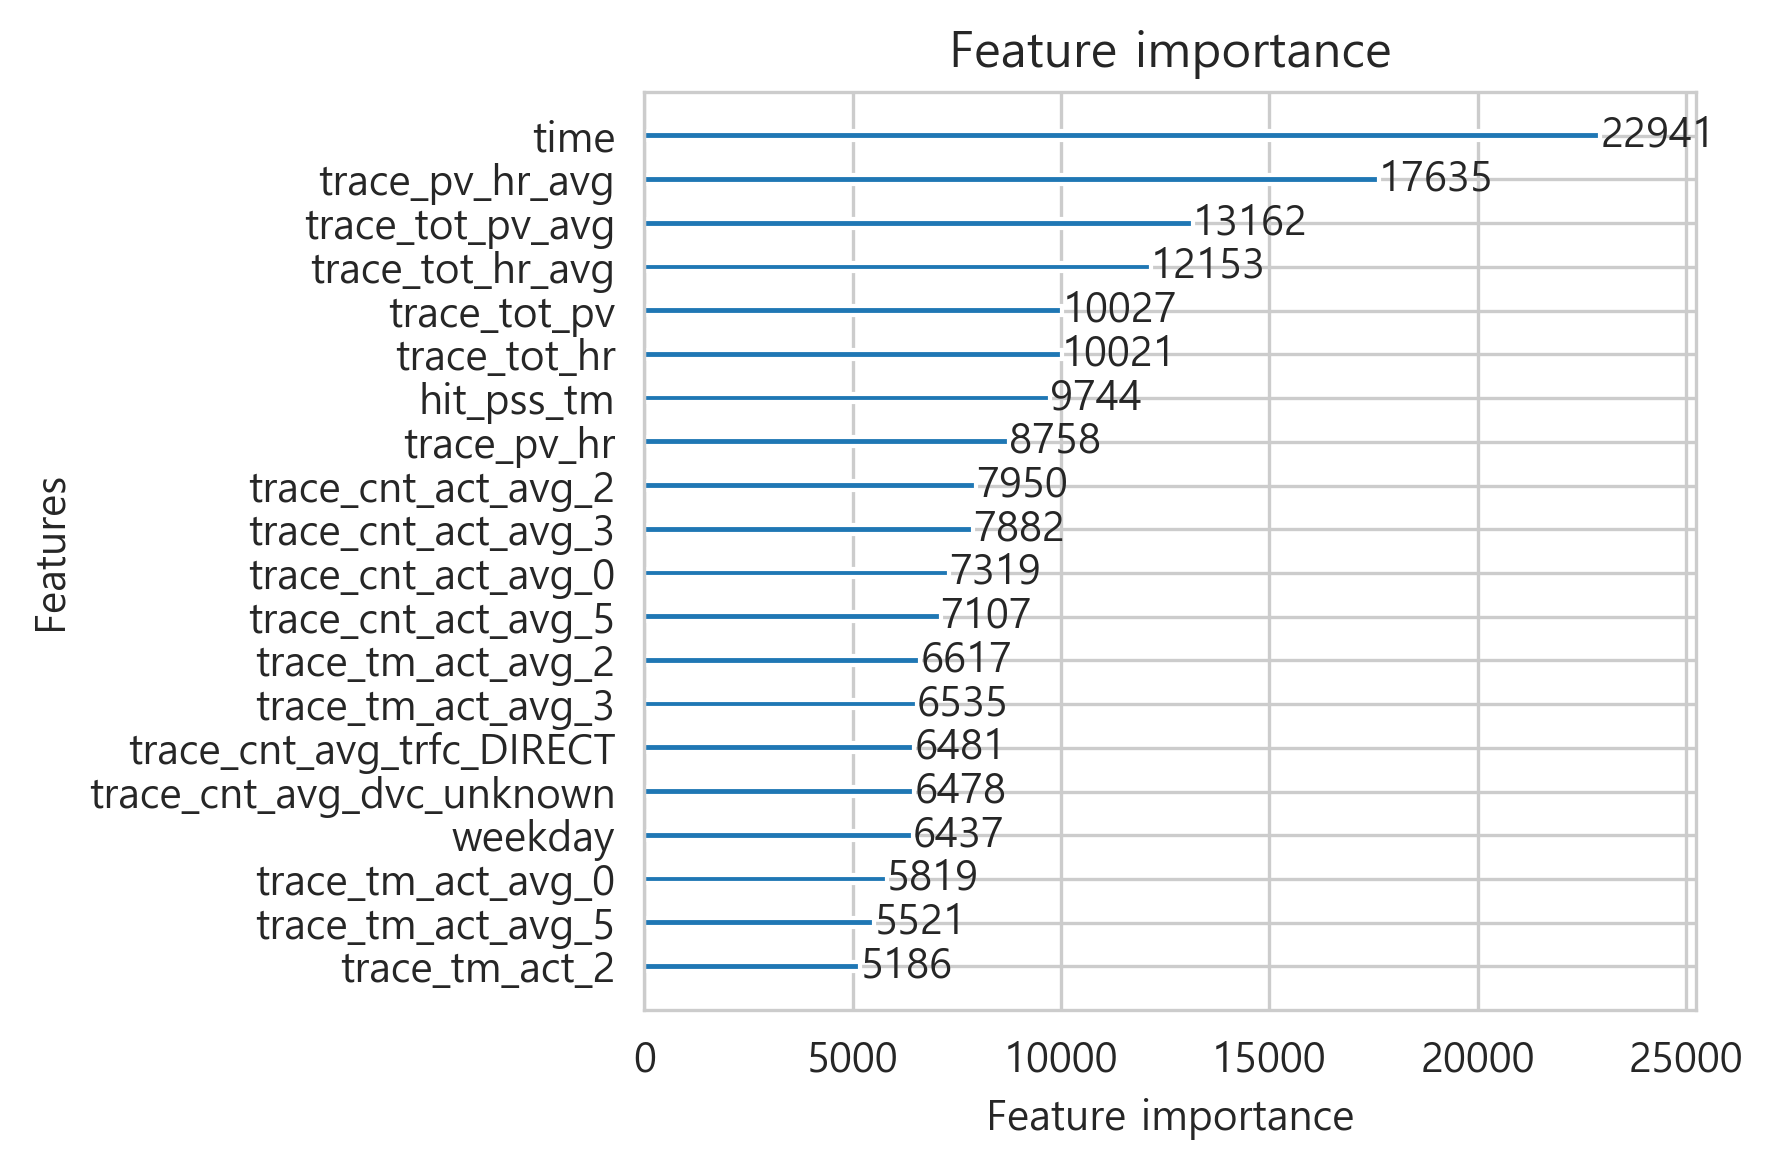

In [42]:
lgb.plot_importance(tracker_improved, dpi=300, max_num_features=20)
plt.tight_layout()
plt.savefig('./tracker/Feature Importance.png', dpi=300)

- 중요 변수를 상위 20개까지 그래프로 그립니다.

## 트래킹

In [43]:
tracker = joblib.load('./tracker/tracker_improved.pkl')

In [44]:
unknown = pd.read_csv('./tracker/unknown.csv')

In [45]:
unknown['dvc_ctg_nm'] = encoder_dvc.transform(unknown['dvc_ctg_nm'])
unknown['trfc_src'] = encoder_trfc.transform(unknown['trfc_src'])
unknown['biz_unit'] = encoder_biz.transform(unknown['biz_unit'])

In [46]:
clnt_id = unknown['clnt_id']
unknown = unknown.drop(columns='clnt_id')

In [47]:
pred_unknown = tracker.predict(unknown[tracker.feature_name()])
unknown['clnt_type'] = pd.DataFrame(pred_unknown).apply(lambda x: x.idxmax(), axis=1)

In [48]:
tracked = unknown.copy()
tracked['clnt_id'] = clnt_id
tracked = tracked[['clnt_id','sess_id','hit_seq','clnt_type']]
tracked.to_csv('./tracker/tracked.csv', index=False)

- 학습한 모델로 비회원을 식별한 후, tracked.csv 파일로 저장합니다.

In [49]:
tracked = pd.read_csv('./tracker/tracked.csv')

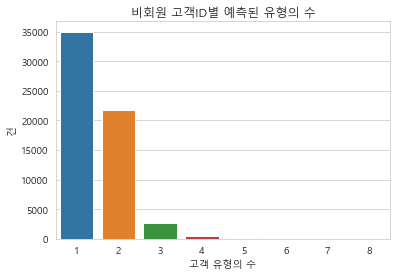

In [50]:
piece = tracked[['clnt_id','clnt_type']].drop_duplicates().groupby('clnt_id')['clnt_type'].nunique().to_frame().reset_index()
sns.countplot(piece['clnt_type'])

plt.title('비회원 고객ID별 예측된 유형의 수')
plt.xlabel('고객 유형의 수'); plt.ylabel('건')

plt.savefig('./tracker/비회원 고객ID별 예측된 유형의 수.png', dpi=300)
plt.show()

- 비회원 고객 ID별로 몇 개의 고객 유형이 예측됐는지 살펴봅니다. 예측되는 수가 적을수록 이 모델의 안정성이 입증됩니다. 하나의 고객 번호에 주로 1~2개의 고객 유형이 예측된 것으로 나타났습니다. 즉, 트래커 모델은 예측 결과가 안정적이라고 할 수 있습니다.

In [51]:
female = sns.color_palette('Reds',5)
male =  sns.color_palette('Blues',5)
palette = {0:female[0], 5:male[0],
           1:female[1], 6:male[1],
           2:female[2], 7:male[2],
           3:female[3], 8:male[3],
           4:female[4], 9:male[4]}

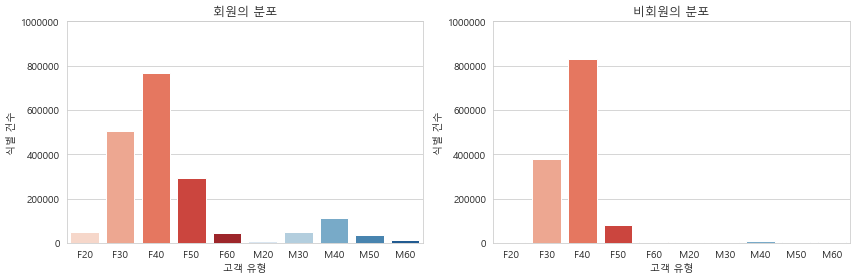

In [52]:
fig = plt.figure(figsize=(12,4))

ax = fig.add_subplot(121)
sns.countplot(target, palette=palette)
ax.set_title('회원의 분포')
ax.set_xlabel('고객 유형'); ax.set_ylabel('식별 건수')
ax.set_ylim(0,1000000)
type_labels=['F20','F30','F40','F50','F60','M20','M30','M40','M50','M60']
ax.set_xticklabels(labels= type_labels)

ax = fig.add_subplot(122)
sns.countplot(tracked['clnt_type'], palette=palette)
ax.set_title('비회원의 분포')
ax.set_xlabel('고객 유형'); ax.set_ylabel('식별 건수')
ax.set_ylim(0,1000000)
type_labels=['F20','F30','F40','F50','F60','M20','M30','M40','M50','M60']
ax.set_xticklabels(labels= type_labels)

fig.tight_layout()
plt.savefig('./tracker/비회원 vs 회원의 분포.png', dpi=300)

plt.show()

- 다음은 예측된 결과의 분포와 실제 회원의 고객 유형 분포를 비교합니다. 예측 결과, 30,40,50대 여성의 비율이 매우 크게 나타나는데, 이는 30,40,50대 여성 회원의 활동량에 기인한 것으로 보입니다. 이 셋을 제외한 결과를 확대하여 살펴봅니다.

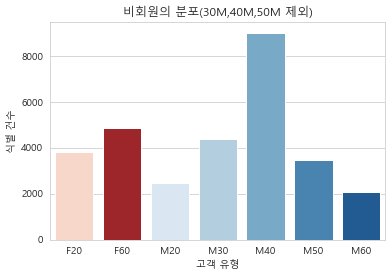

In [53]:
filtered = tracked.loc[~tracked['clnt_type'].isin([1,2,3]),'clnt_type']

fig = plt.figure()
sns.countplot(filtered, palette=palette)
plt.title('비회원의 분포(30M,40M,50M 제외)')
plt.xlabel('고객 유형'); plt.ylabel('식별 건수')
type_labels=['F20','F60','M20','M30','M40','M50','M60']
plt.xticks(ticks=np.arange(7), labels= type_labels)
plt.savefig('./tracker/비회원의 분포(2).png', dpi=300)

plt.show()

- 나머지의 분포는 예측된 수가 적으나 회원의 분포와 일치하는 것을 확인할 수 있습니다. 결론적으로, 비회원의 행동 패턴은 대부분이 30,40,50대 여성의 패턴과 일치하는 것으로 보입니다.